In [6]:
# <-- Import libraries, custom functions, and load configuration & datasets <-- #

import yaml
import datetime as dt
import re
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
import seaborn as sns

from statsmodels.multivariate.manova import MANOVA
from scipy import stats
from scipy.stats import pearsonr, boxcox, chi2_contingency, shapiro, probplot
from scipy.stats.contingency import association

sns.set(style="whitegrid")

# <-- Imports custom preprocessing functions from 'functions.py' <-- #

# from functions import ()

# <-- Loads YAML configuration to dynamically reference CSV output files. <-- #

config = None  # <-- Initialize config
try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")

df_proc_control = pd.read_csv(config['output_data']['file6'])
df_proc_test = pd.read_csv(config['output_data']['file7'])

In [11]:
df_proc_control.columns

Index(['client_id', 'visitor_id', 'visit_id', 'reached_start',
       'reached_step_1', 'reached_step_2', 'reached_step_3', 'reached_confirm',
       'completed', 't_start_step1', 't_step1_step2', 't_step2_step3',
       't_step3_conf', 't_total', 'n_back_jumps', 'outcome'],
      dtype='object')

In [7]:
plt.rcParams['figure.figsize'] = (7,4)

# 1) Elige las columnas numéricas donde quieres buscar outliers
NUM_COLS = [
    't_total','t_start_step1','t_step1_step2','t_step2_step3','t_step3_conf','n_back_jumps'
]

In [8]:
# 2) Cálculo simple de límites IQR
def iqr_bounds(s: pd.Series, k: float = 3.0):
    x = s.dropna().values
    if len(x) == 0:
        return np.nan, np.nan
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    return q1 - k*iqr, q3 + k*iqr

In [9]:
# 3) Escaneo rápido (imprime conteos y dibuja 2 gráficos por variable)
def quick_outlier_scan(df: pd.DataFrame, cols=NUM_COLS, k: float = 3.0, title_prefix:str=""):
    for c in cols:
        lo, hi = iqr_bounds(df[c], k)
        n_out = int(((df[c] < lo) | (df[c] > hi)).sum())
        print(f"{title_prefix}{c}: outliers={n_out}, low={lo:.3f}, high={hi:.3f}")

        # Boxplot con límites IQR
        ax = sns.boxplot(x=df[c])
        if np.isfinite(lo): ax.axvline(lo, ls='--')
        if np.isfinite(hi): ax.axvline(hi, ls='--')
        ax.set_title(f"{title_prefix}{c} (box + IQR)"); plt.show()

        # Histograma simple
        sns.histplot(df[c], kde=True)
        if np.isfinite(lo): plt.axvline(lo, ls='--')
        if np.isfinite(hi): plt.axvline(hi, ls='--')
        plt.title(f"{title_prefix}{c} (hist)"); plt.show()

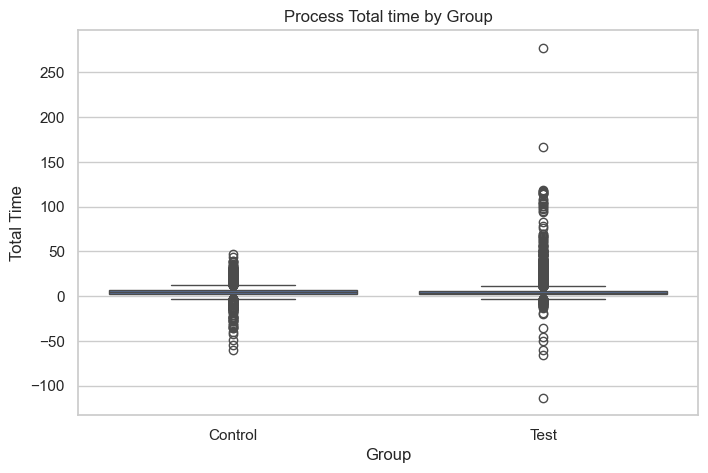

In [14]:
# Escaneo visual y conteos
# quick_outlier_scan(df_proc_control, title_prefix="[CONTROL] ")
# quick_outlier_scan(df_proc_test,    title_prefix="[TEST] ")

df_age_combined = pd.concat([
    pd.DataFrame({'ttime': df_proc_control['t_total'].dropna(), 'Group': 'Control'}),
    pd.DataFrame({'ttime': df_proc_test['t_total'].dropna(), 'Group': 'Test'})
])

plt.figure(figsize=(8, 5))
sns.boxplot(x='Group', y='ttime', data=df_age_combined)
plt.title('Process Total time by Group')
plt.xlabel('Group')
plt.ylabel('Total Time')
plt.show()